In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import find_peaks, periodogram, windows, lombscargle, medfilt, peak_prominences
from scipy.ndimage import gaussian_filter1d
from dipper.data_utils.utils import *

# Periodogram and dominant peak analysis

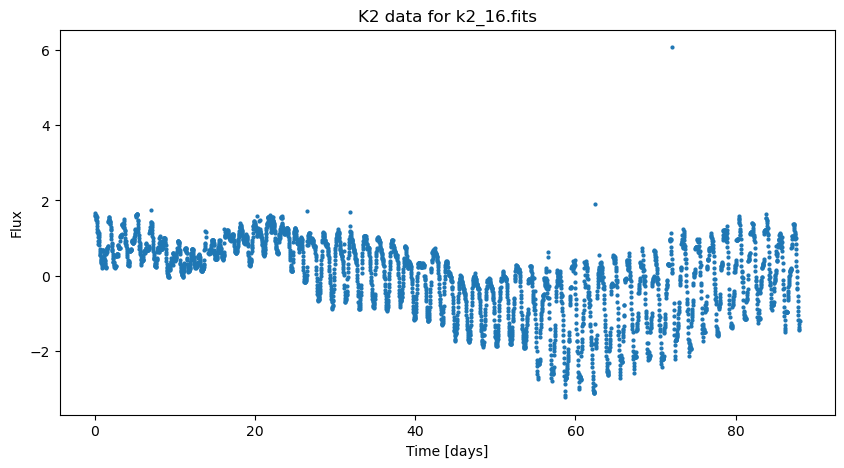

In [6]:
# Load some data
filenumber = 16 #0, 16, 13, 28, 62
data_dir = '../../data/k2/'
filename = f'k2_{filenumber}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, y_err, fmt='o', markersize=2)
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.title(f'K2 data for {filename}')
plt.show()

In [7]:
def freq_idx_to_period_days(freqs_idx, times):
    idx_day_scale_factor = (times[-1] - times[0]) / len(times)
    periods = 1 / freqs_idx
    periods_days = periods * idx_day_scale_factor

    return periods_days

Peaks: [87.97916667  1.7250817   1.65998428]
Prominences: [1723.94779469  319.93827362  268.00700866]
Left bases: [       inf 1.7954932  1.69190705]
Right bases: [29.32638889  1.69190705  1.59962121]


/tmp/ipykernel_14564/3056681042.py:3: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs_idx


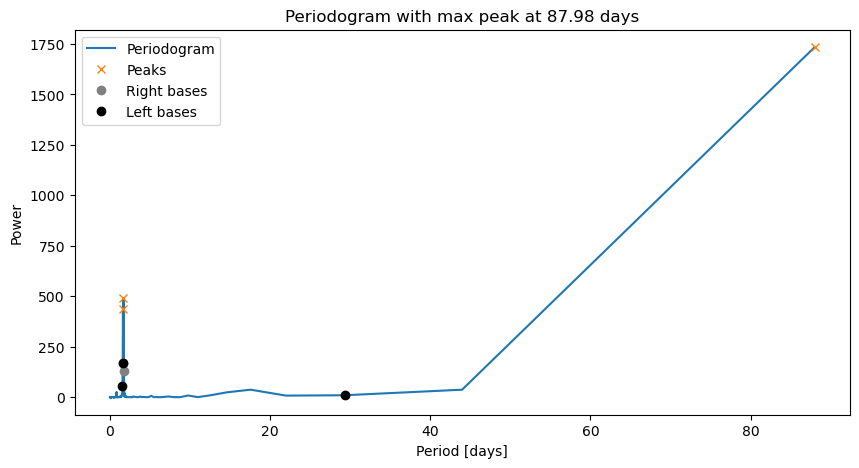

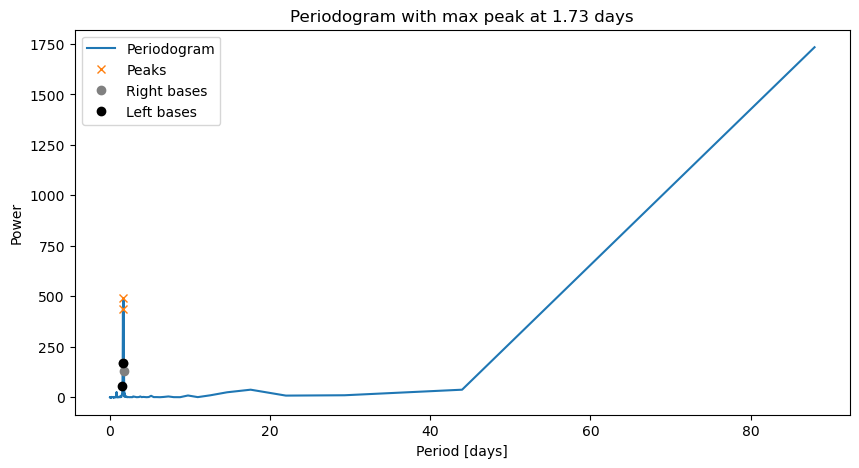

In [8]:
freqs, power = periodogram(y)
peaks, _ = find_peaks(power, prominence=50)
prominences, left_bases, right_bases = peak_prominences(power, peaks, wlen=5)
max_peak = np.argmax(power[peaks])
dominant_period = freq_idx_to_period_days(freqs[peaks[max_peak]], x)

print(f'Peaks: {freq_idx_to_period_days(freqs[peaks], x)}')
print(f'Prominences: {prominences}')
print(f'Left bases: {freq_idx_to_period_days(freqs[left_bases], x)}')
print(f'Right bases: {freq_idx_to_period_days(freqs[right_bases], x)}')

plt.figure(figsize=(10, 5))
plt.plot(freq_idx_to_period_days(freqs, x), power, label='Periodogram')
plt.plot(freq_idx_to_period_days(freqs[peaks], x), power[peaks], 'x', label='Peaks')
plt.plot(freq_idx_to_period_days(freqs[left_bases], x), power[left_bases], 'o', c='gray', label='Right bases') # Reversed bc period = 1/frequency
plt.plot(freq_idx_to_period_days(freqs[right_bases], x), power[right_bases], 'o', c='black', label='Left bases') # Reversed bc period = 1/frequency
plt.legend()
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title(f'Periodogram with max peak at {dominant_period:.2f} days')
plt.show()

# If the left_base is 0 or the right_base is the last index, the peak is at the edge of the periodogram. Then we remove it
valid_peaks = np.where((left_bases != 0) & (right_bases != len(power) - 1))
if valid_peaks[0].shape[0] == 0:
    print('No valid peaks found according to criteria that base is not at edge of periodogram. Thus we keep all peaks')
else:
    peaks = peaks[valid_peaks]
    left_bases = left_bases[valid_peaks]
    right_bases = right_bases[valid_peaks]
max_peak = np.argmax(power[peaks])
dominant_period = freq_idx_to_period_days(freqs[peaks[max_peak]], x)

plt.figure(figsize=(10, 5))
plt.plot(freq_idx_to_period_days(freqs, x), power, label='Periodogram')
plt.plot(freq_idx_to_period_days(freqs[peaks], x), power[peaks], 'x', label='Peaks')
plt.plot(freq_idx_to_period_days(freqs[left_bases], x), power[left_bases], 'o', c='gray', label='Right bases') # Reversed bc period = 1/frequency
plt.plot(freq_idx_to_period_days(freqs[right_bases], x), power[right_bases], 'o', c='black', label='Left bases') # Reversed bc period = 1/frequency
plt.legend()
plt.xlabel('Period [days]')
plt.ylabel('Power')
plt.title(f'Periodogram with max peak at {dominant_period:.2f} days')
plt.show()

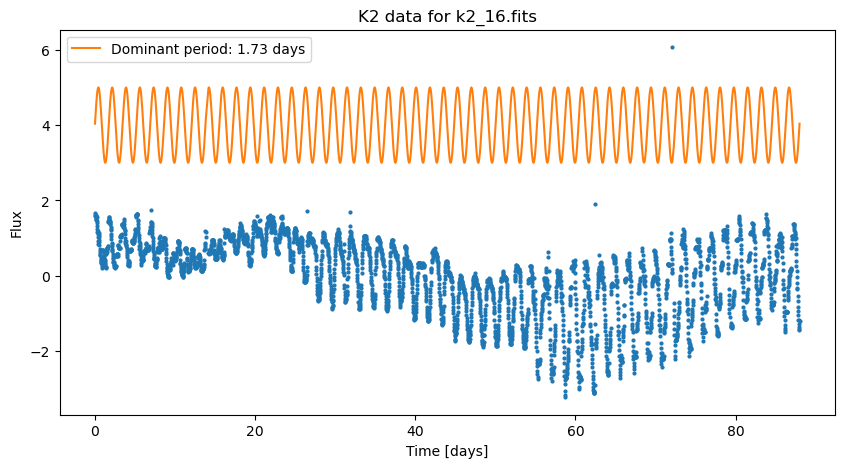

In [9]:
# Plot lightcurve with dominant period sinusoid
plt.figure(figsize=(10, 5))
plt.errorbar(x, y, y_err, fmt='o', markersize=2)
plt.plot(x, np.sin(2 * np.pi * x / dominant_period) + 4, label=f'Dominant period: {dominant_period:.2f} days')
plt.xlabel('Time [days]')
plt.ylabel('Flux')
plt.title(f'K2 data for {filename}')
plt.legend()
plt.show()

# Make a whitenoise lightcurve called "k2_whitenoise.fits"

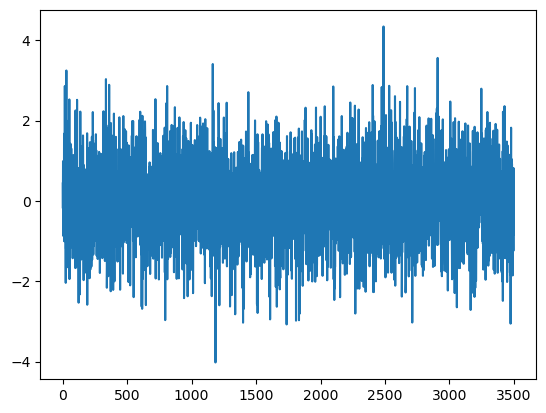

In [ ]:
# Make a whitenoise lightcurve
save_dir = "../../data/"
save_name = "whitenoise.fits"

# Be whitenoise, with a SNR of 1, and length 3500 indices
mean = 0
std = 1 
num_samples = 3500
samples = np.random.normal(mean, std, size=num_samples)

# It must have an x, which is the time index, y, which is the flux, and yerr, which is the error on the flux
x = np.arange(num_samples)
y = samples
y_err = np.ones(num_samples) * std

# Save x, y, and y_err in a fits file
hdu = fits.PrimaryHDU()
hdu.data = np.array([x, y, y_err])
hdu.writeto(save_dir + save_name, overwrite=True)

plt.plot(samples)
plt.show()

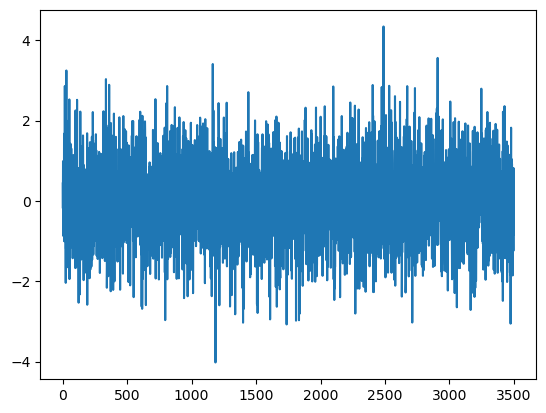

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fits file
hdu = fits.open(save_dir + save_name)
x_load = hdu[0].data[0]
y_load = hdu[0].data[1]
yerr_load = hdu[0].data[2]

# Convert to native byte order
x_load = x_load.byteswap().newbyteorder()
y_load = y_load.byteswap().newbyteorder()
yerr_load = yerr_load.byteswap().newbyteorder()

torch.tensor(x_load, dtype=torch.float32).to(device)

plt.plot(x_load, y_load)

# Synthetic data

Anomaly depth: -21.031226506795583
Anomaly FWHM: 747.2513153785485


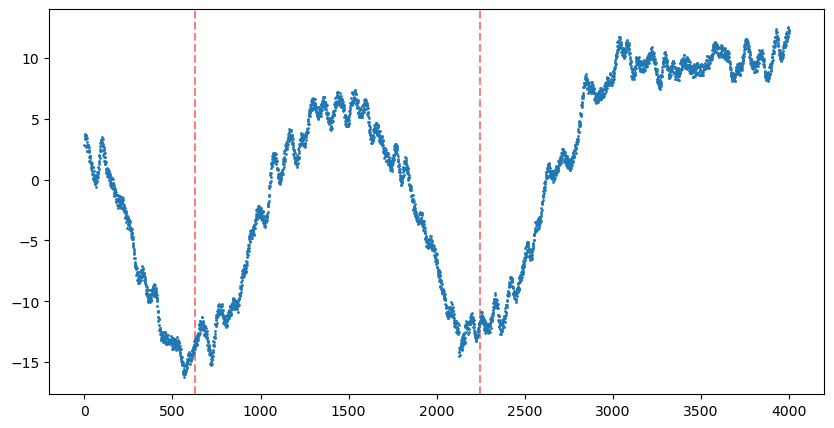

Anomaly depth: -1.39964850111273
Anomaly FWHM: 17.709259133934417


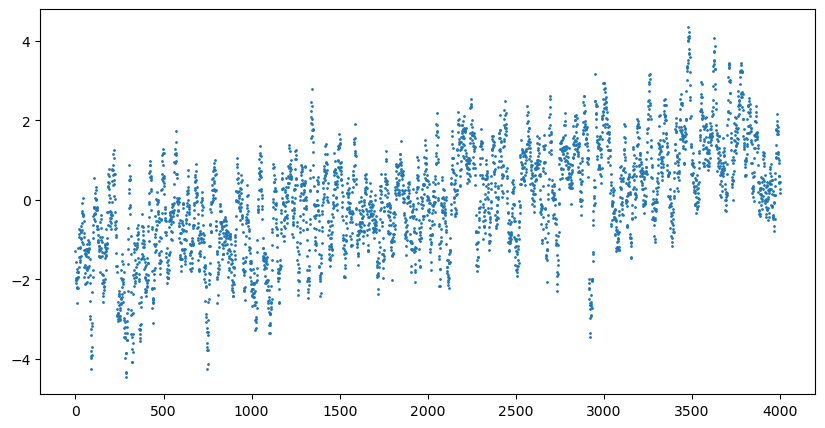

Anomaly depth: -3.5170486598736703
Anomaly FWHM: 155.92679141848973


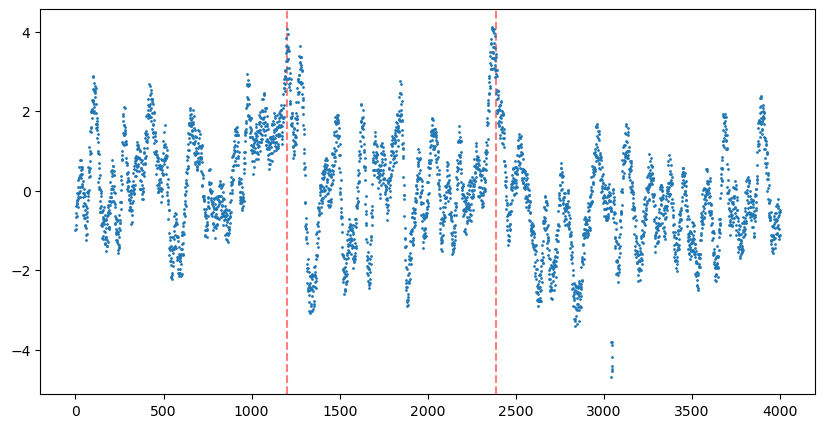

In [12]:
# create a few signals and plot them
for seed in range(3):
    x, y, anomaly_locs, anomaly_amp, anomaly_fwhm = generate_synthetic_lc(num_steps=4000, seed=seed, num_anomalies=np.random.randint(0, 3), shapes=["gaussian", "saw"])
    plt.figure(figsize=(10,5))
    for i in range(len(anomaly_locs)):
        plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
    plt.plot(x, y, '.', markersize=2)
    plt.show()

# Injected anomaly

In [ ]:
# Load the data
filenumber = 68
data_dir = '../../data/k2/'
filename = f'k2_{filenumber}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

Anomaly depth: -1.8872034546910508
Anomaly FWHM: 7.921059825316845


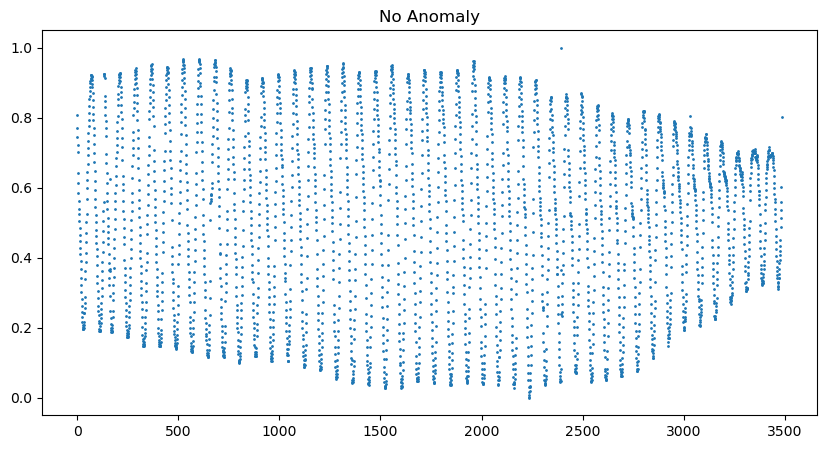

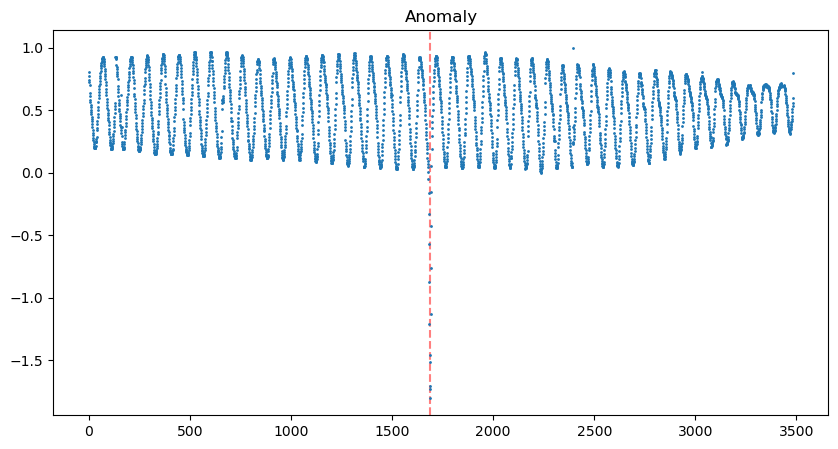

In [7]:
# Inject anomalies
steps, y_new, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=filenumber, 
    shapes=["gaussian"],
    width_scale=0.1,
    depth_scale=1
)

# Plot
plt.figure(figsize=(10,5))
plt.plot(steps, y, '.', markersize=2)
plt.title("No Anomaly")

plt.figure(figsize=(10,5))
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
plt.plot(steps, y_new, '.', markersize=2)
plt.title("Anomaly")
plt.show()

### Check Periodogram and peak/shoulder of PS to make sure it scales correctly

In [8]:
min_period = np.inf 
max_period = -1 * np.inf

# Investigate the periodogram and peaks
for filenumber in range(78):
    # Load the data
    data_dir = '../../data/k2/'
    filename = f'k2_{filenumber}.fits'
    x, y, y_err = load_k2_data(data_dir + filename)

    # Generate periodogram
    freqs, power = periodogram(y)
    peaks, _ = find_peaks(power)
    dominant_peak = peaks[np.argmax(power[peaks])]
    dominant_period = 1 / freqs[dominant_peak]

    # Get shoulder of ps
    smooth_power = gaussian_filter1d(power, 2)
    slope = np.gradient(smooth_power, freqs)
    shoulder_idx = np.where(slope < 0)[0][0]
    dominant_shoulder = 1 / freqs[shoulder_idx]

    # Convert dominant period to scale of x
    dom_period_convert = dominant_period * (x[-1] - x[0]) / len(x)
    dom_shoulder_convert = dominant_shoulder * (x[-1] - x[0]) / len(x)

    # Find min and max period
    if dom_period_convert < min_period:
        min_period = dom_period_convert
    if dom_period_convert > max_period:
        max_period = dom_period_convert

    # plot the lightcurve and periogram side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the lightcurve
    axs[0].plot(x, y, '.', markersize=2)
    axs[0].set_title(f"Light Curve {filename}")

    # Plot the periodogram in log scale
    axs[1].plot(freqs, power)
    axs[1].set_title(f"Periodogram with dominant period: {dom_period_convert:.2f} and shoulder period: {dom_shoulder_convert:.2f}")
    axs[1].axvline(x=freqs[dominant_peak], color='r', linestyle='--', alpha=0.5)
    axs[1].set_xscale('log')

    plt.savefig(data_dir + f"visualizations/periodogram_k2_{filenumber}.png")
    plt.close()

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:189: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))
/tmp/ipykernel_768895/2906578784.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  dominant_shoulder = 1 / freqs[shoulder_idx]


In [9]:
print(f"Min period: {min_period}")
print(f"Max period: {max_period}")

Min period: 0.42232789855072467
Max period: 87.97916666666667
